In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


## Introduction

##### Based on the presented data, it is necessary to build a linear classification model and, based on this model, try to accurately predict the presence of a kidney stone.

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings

warnings.filterwarnings('ignore')
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (10,8)
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 500

## Load data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')

## Preliminary analyse

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [5]:
train.sample(5)

id  gravity    ph  osmo  cond  urea  calc  target
182  182    1.017  5.87   410  23.6   252  2.46       1
249  249    1.015  6.79   371  11.2   188  2.64       1
340  340    1.023  5.58   874  27.6   516  7.31       0
300  300    1.008  6.88   253   9.8   133  0.65       0
328  328    1.025  5.60   840  24.5   395  7.64       1

In [6]:
train.iloc[:,1:-1].describe()

gravity          ph         osmo        cond        urea        calc
count  414.000000  414.000000   414.000000  414.000000  414.000000  414.000000
mean     1.017894    5.955459   651.545894   21.437923  278.657005    4.114638
std      0.006675    0.642260   234.676567    7.514750  136.442249    3.217641
min      1.005000    4.760000   187.000000    5.100000   10.000000    0.170000
25%      1.012000    5.530000   455.250000   15.500000  170.000000    1.450000
50%      1.018000    5.740000   679.500000   22.200000  277.000000    3.130000
75%      1.022000    6.280000   840.000000   27.600000  385.000000    6.630000
max      1.040000    7.940000  1236.000000   38.000000  620.000000   14.340000

## Exploratory data analysis

### Plot some statistics graphics for each features our data

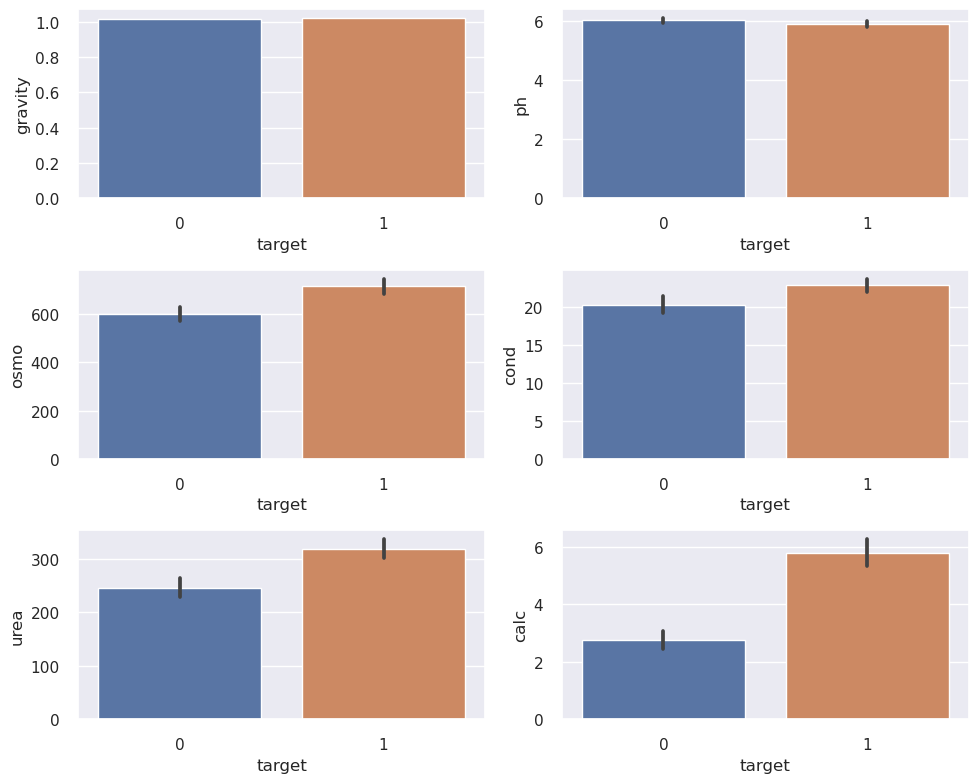

In [7]:
sns.set_theme()
data_1 = train.iloc[:,1:-1]
for i in range(6):
    plt.subplot(3,2,i+1)
    col = data_1.iloc[:,i]
    sns.barplot(data=train, x='target', y=col)
plt.tight_layout()    
plt.show()

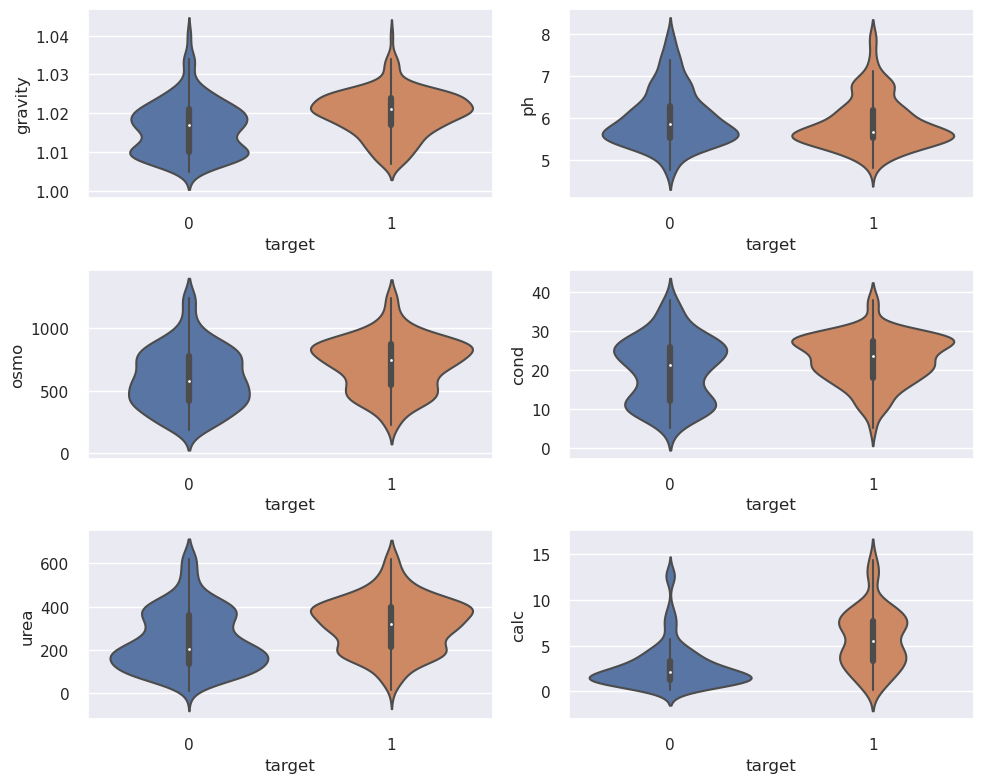

In [8]:
sns.set_theme()
data_1 = train.iloc[:,1:-1]
for i in range(6):
    plt.subplot(3,2,i+1)
    col = data_1.iloc[:,i]
    sns.violinplot(data=train, x='target', y=col)
plt.tight_layout()    
plt.show()

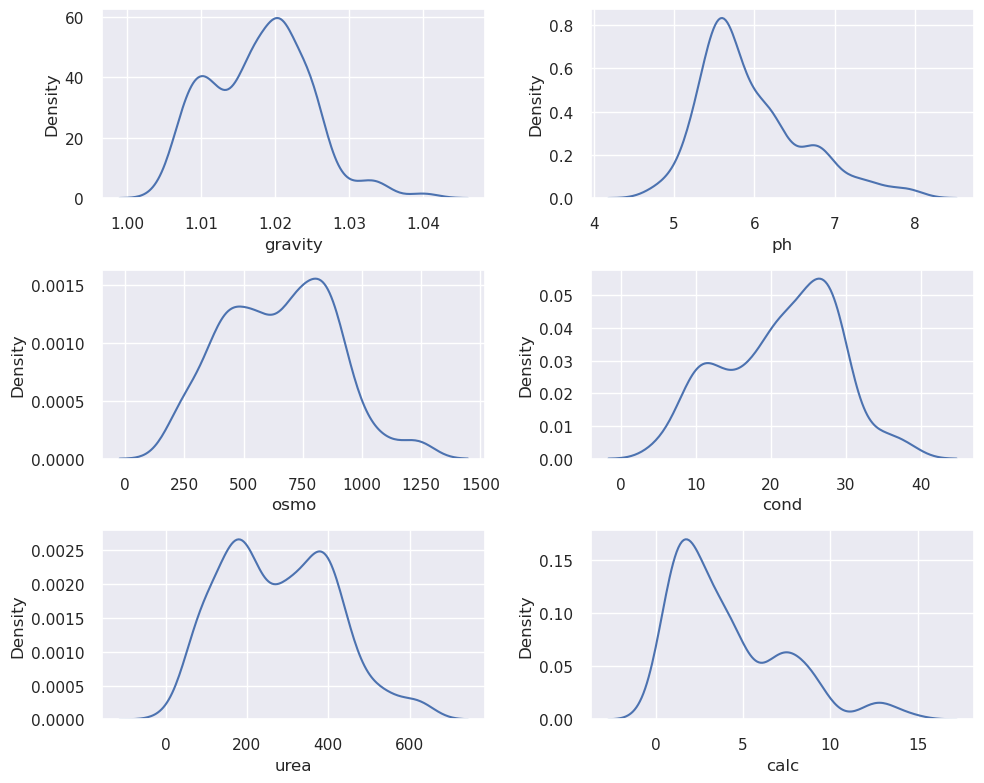

In [9]:
sns.set_theme()
data_1 = train.iloc[:,1:-1]
for i in range(6):
    plt.subplot(3,2,i+1)
    sns.kdeplot(data=data_1,x=data_1.columns[i])
plt.tight_layout()    
plt.show()

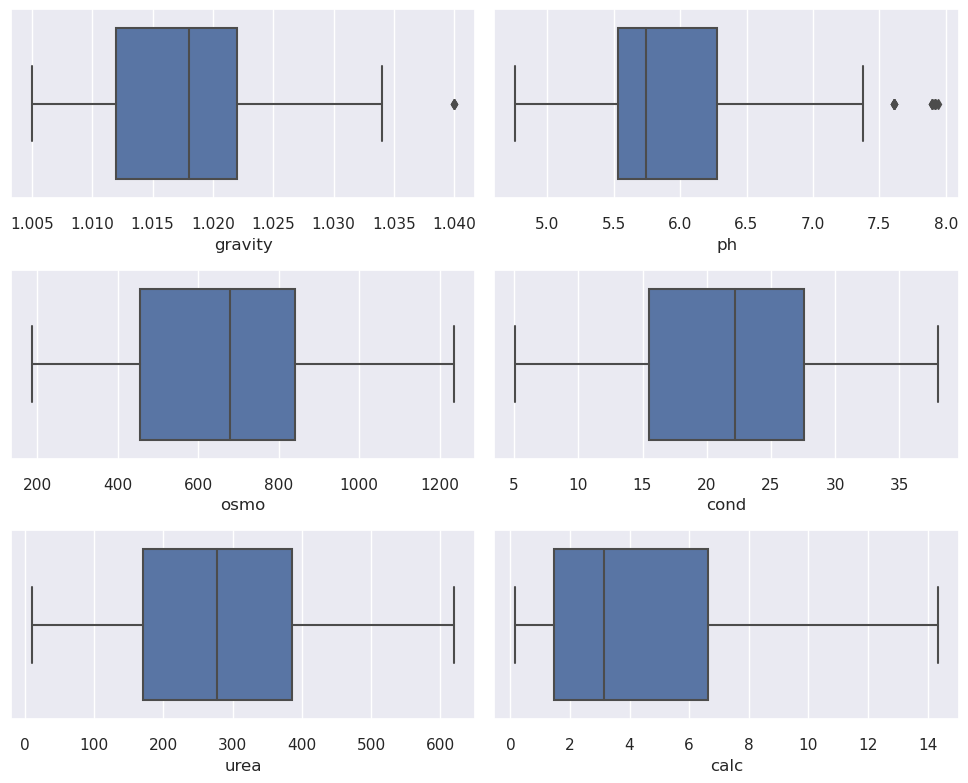

In [10]:
sns.set_theme()
data_1 = train.iloc[:,1:-1]
for i in range(6):
    plt.subplot(3,2,i+1)
    sns.boxplot(data=data_1,x=data_1.columns[i])
plt.tight_layout()    
plt.show()

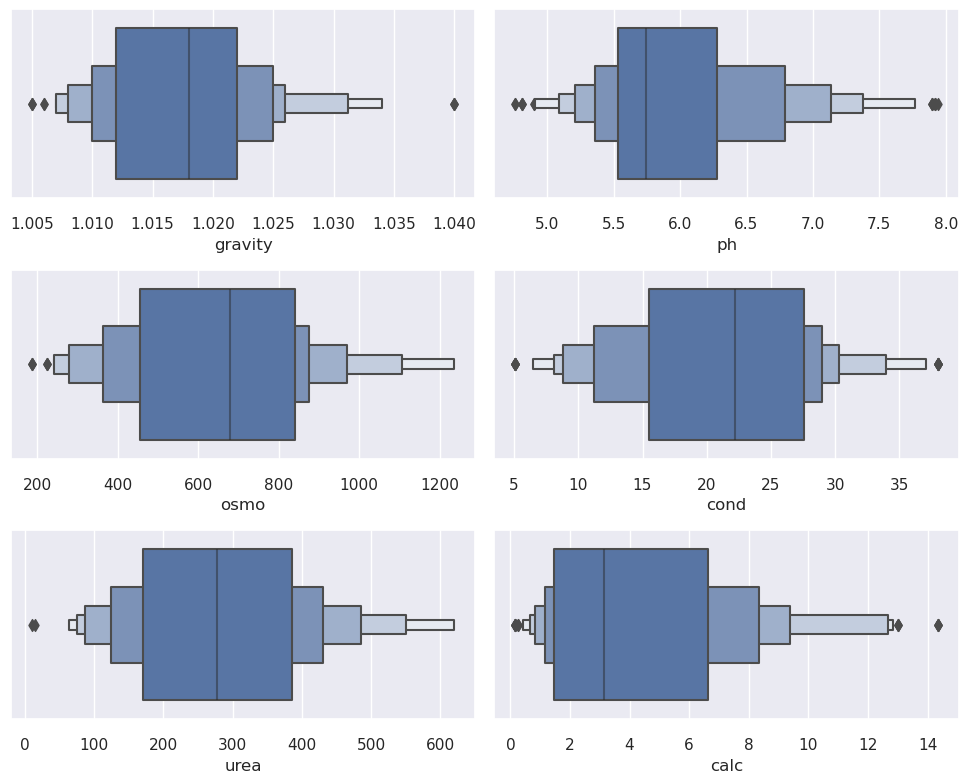

In [11]:
sns.set_theme()
data_1 = train.iloc[:,1:-1]
for i in range(6):
    plt.subplot(3,2,i+1)
    sns.boxenplot(data=data_1,x=data_1.columns[i])
plt.tight_layout()    
plt.show()

### Pairplot features of data with use scatter kind

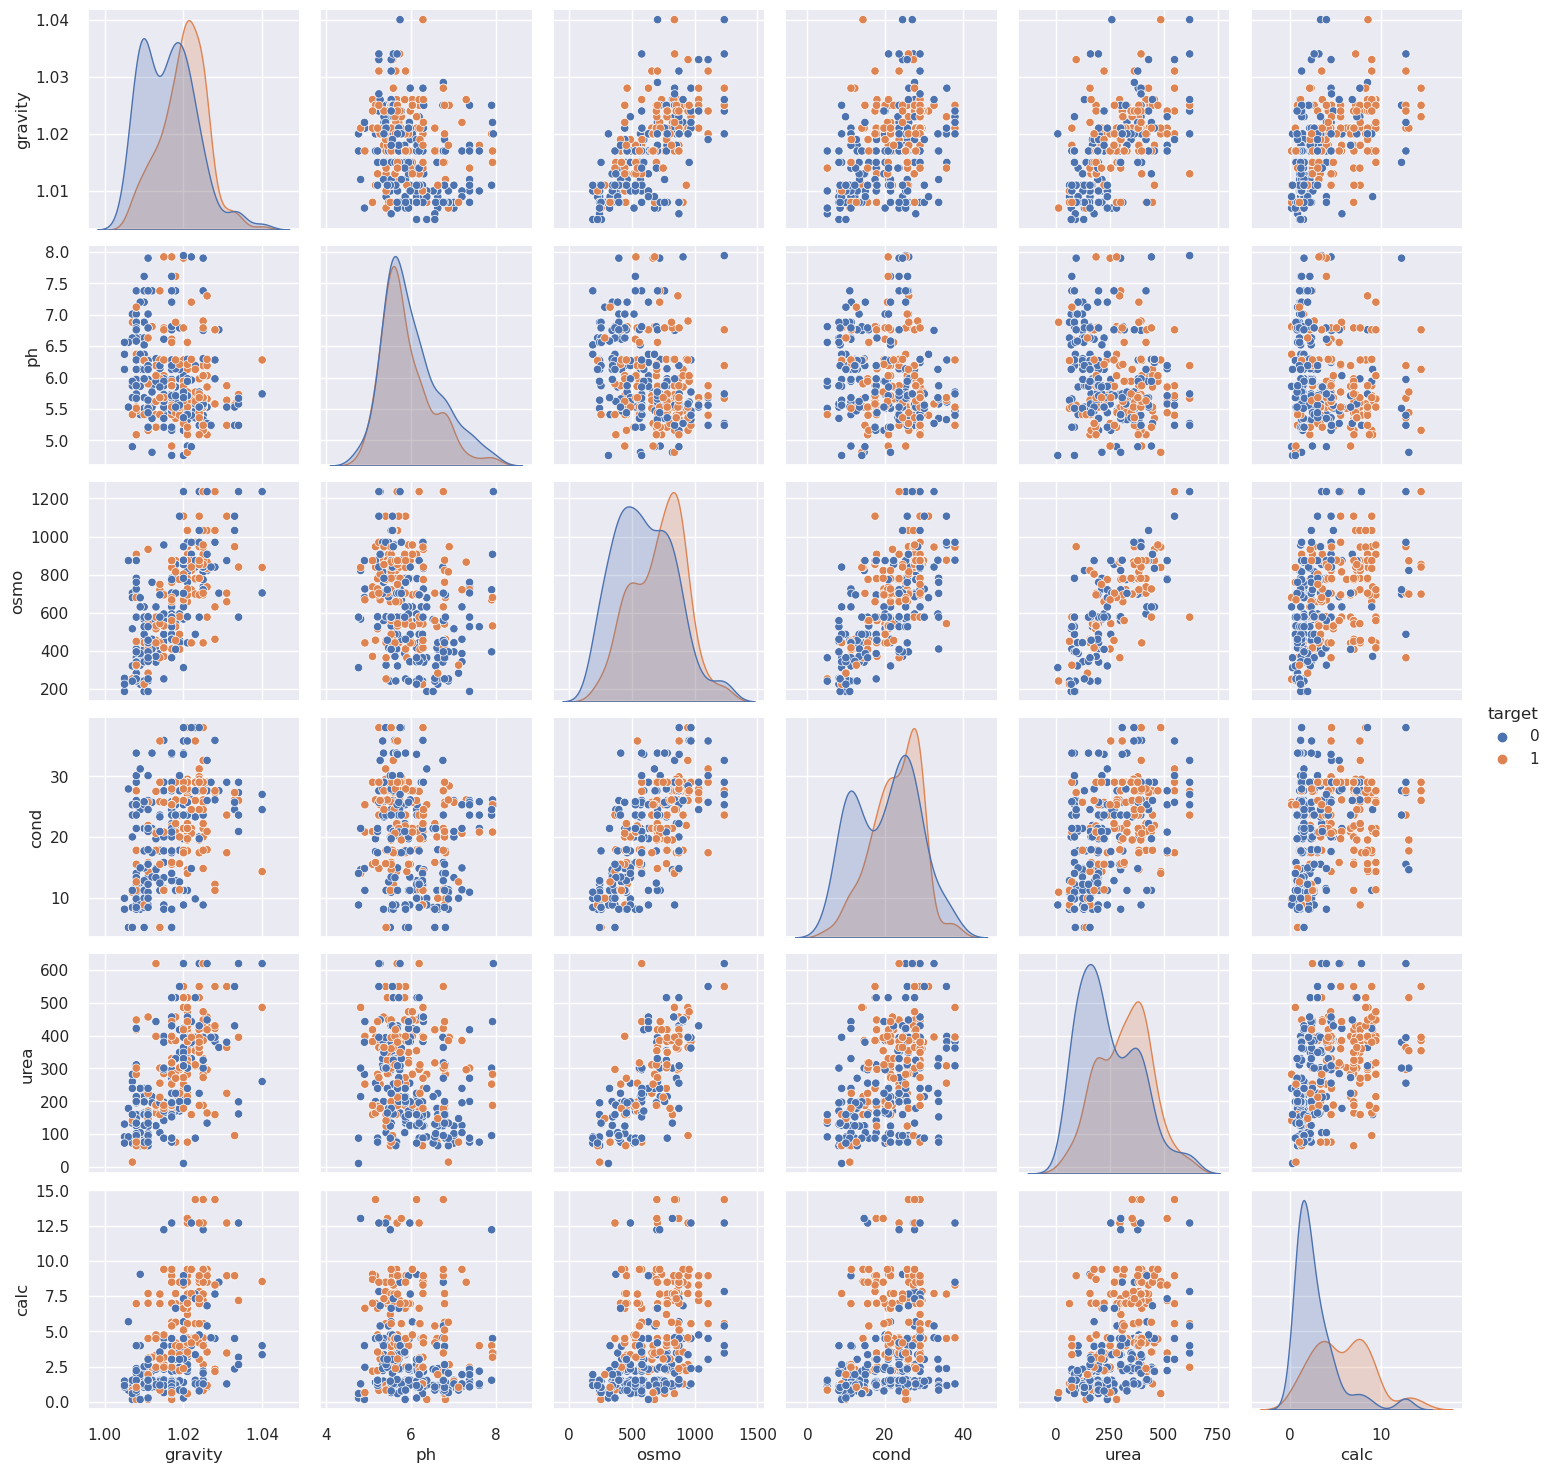

In [12]:
sns.set_theme()
sns.pairplot(train.iloc[:,1:], hue='target', kind='scatter');

### With use kde kind

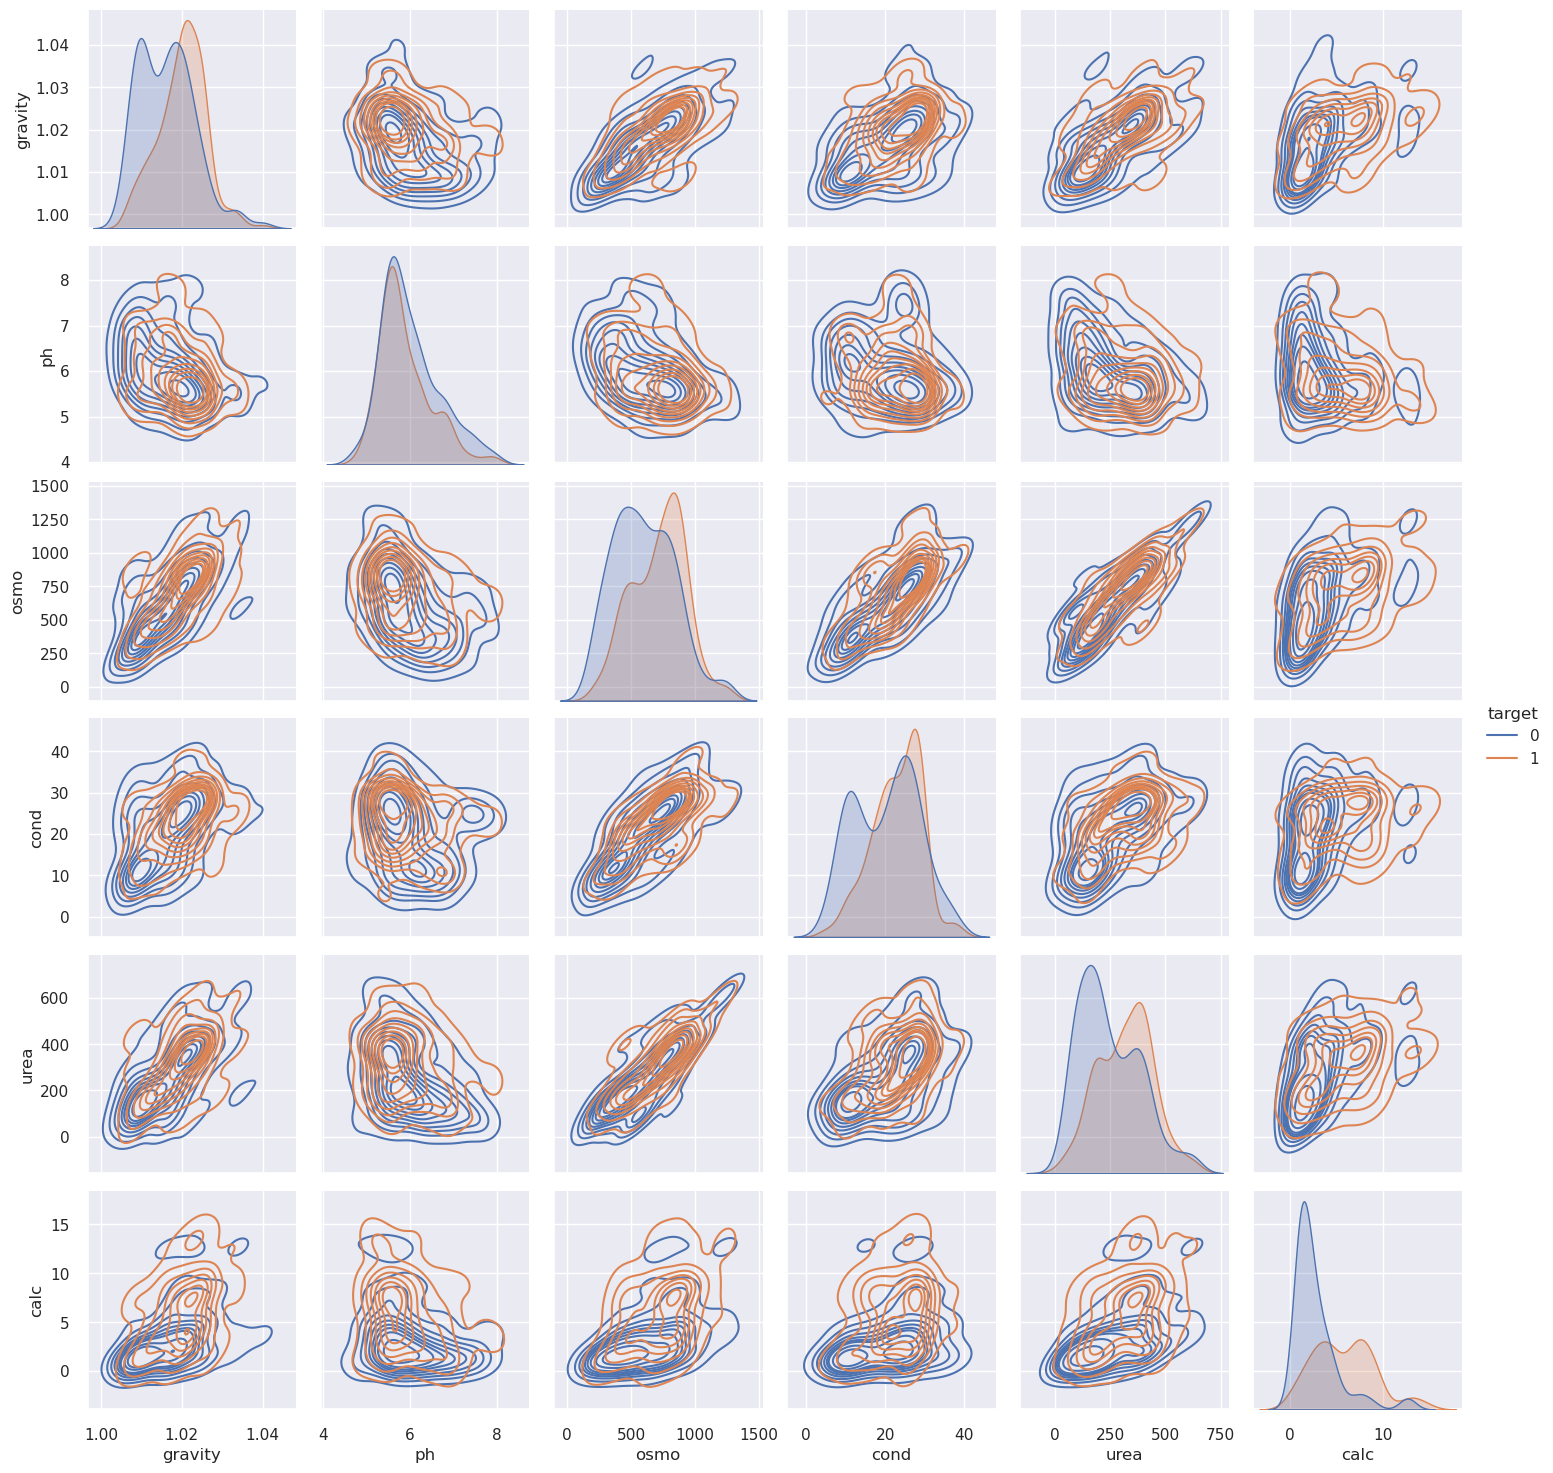

In [13]:
sns.set_theme()
sns.pairplot(train.iloc[:,1:], kind='kde', hue='target');

### Pairplot with reg kind 

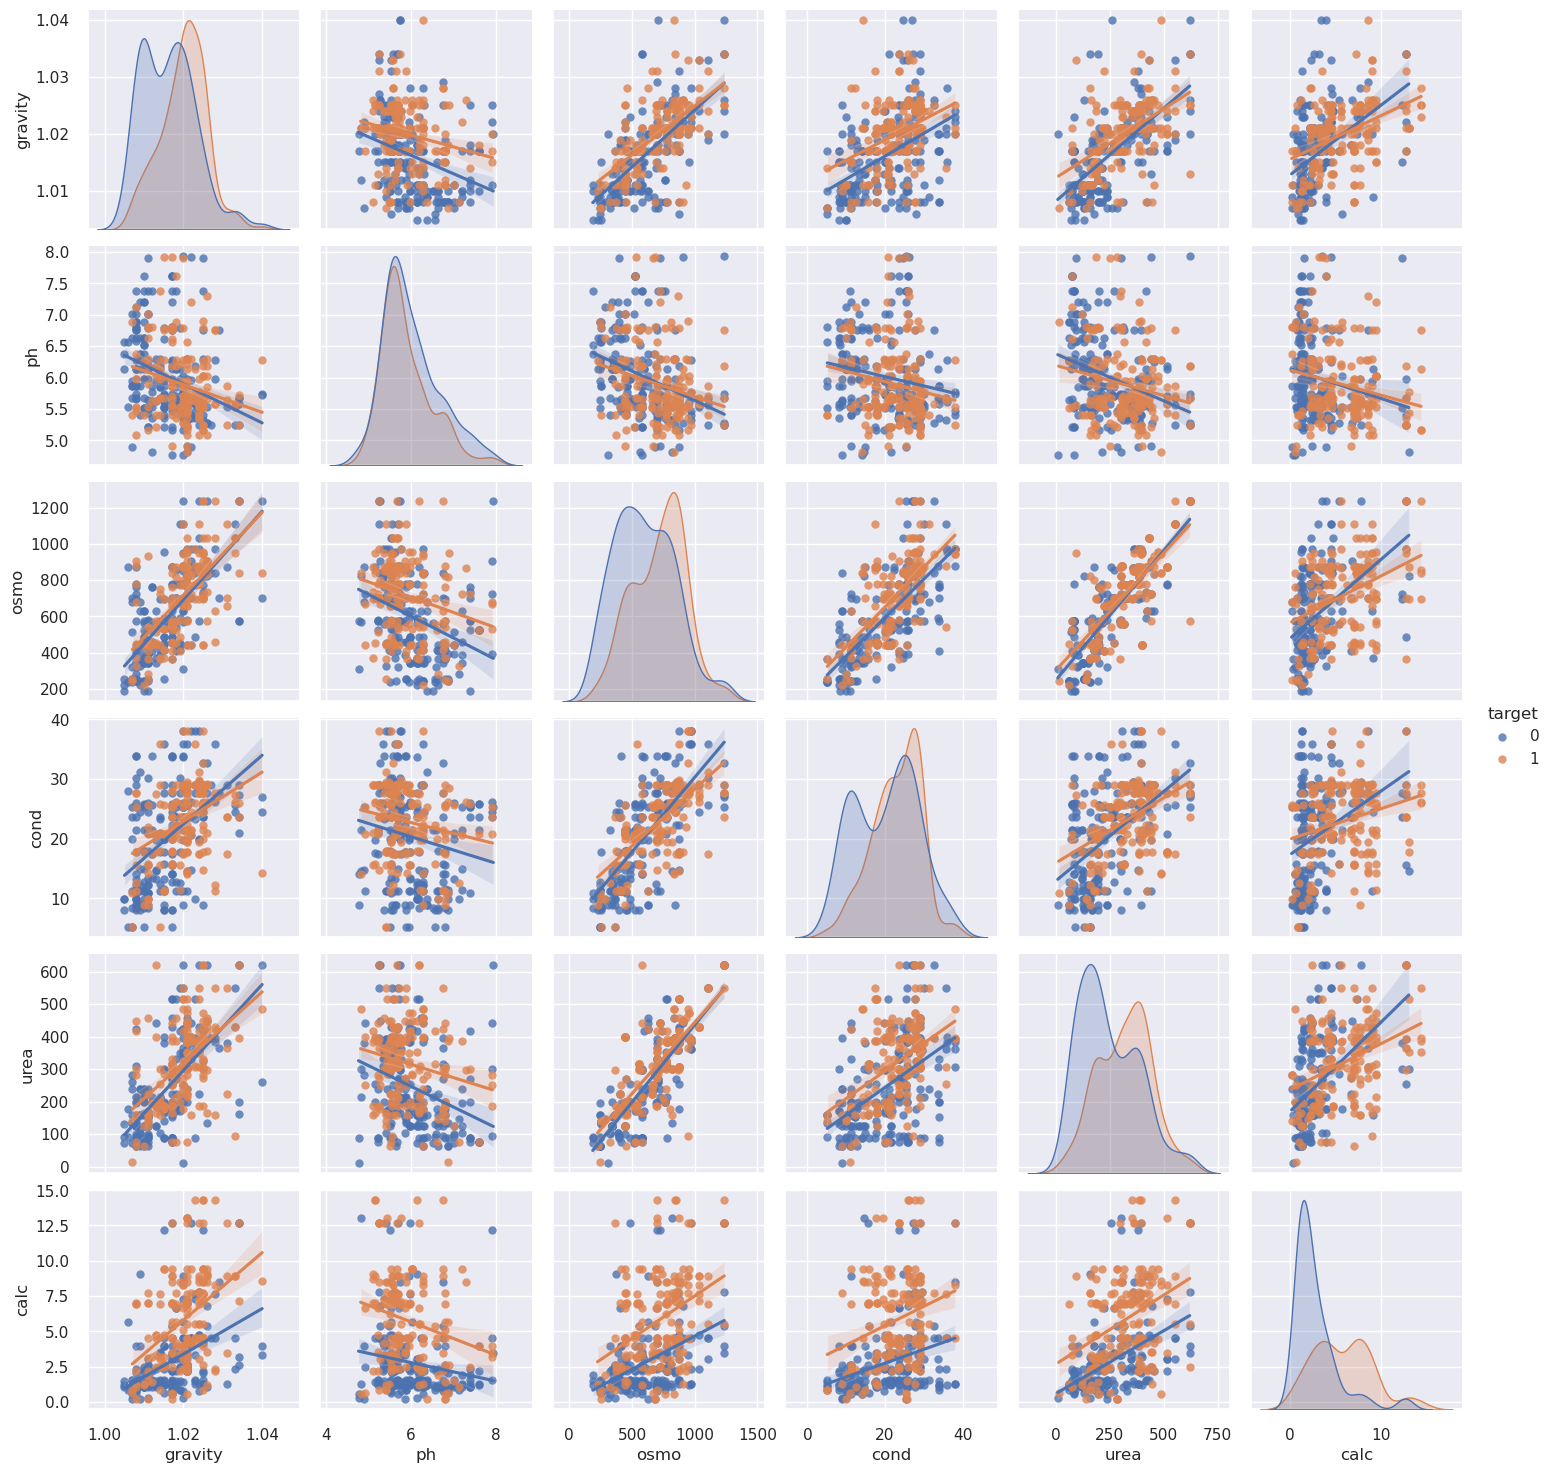

In [14]:
sns.set_theme()
sns.pairplot(train.iloc[:,1:], kind='reg', diag_kind='kde', hue='target');

### Let's build a correlation map of features

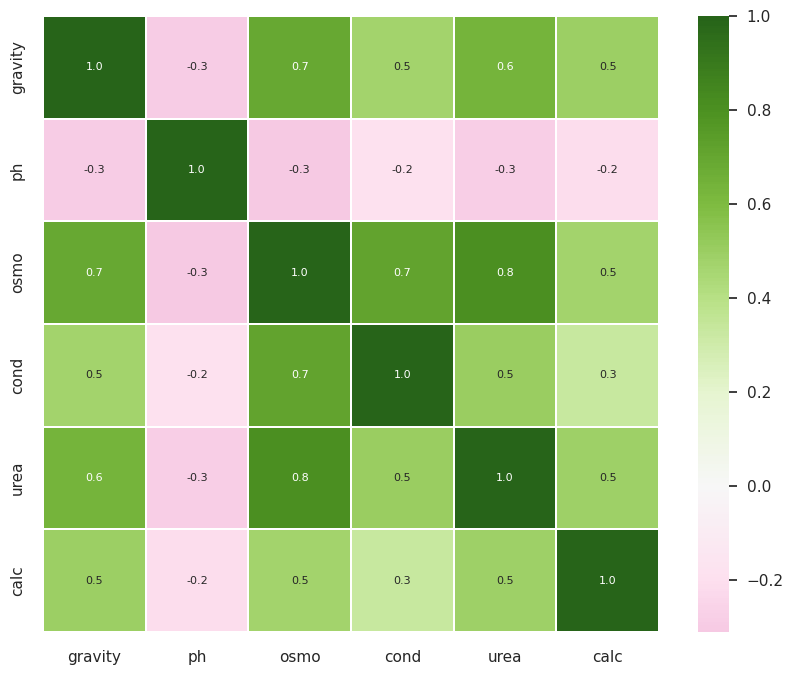

In [15]:
sns.set_theme()
sns.heatmap(train.iloc[:,1:-1].corr(), cmap="PiYG", center=0,
    annot_kws={"size": 8}, fmt='.1f', linewidths=0.1, square=True, annot=True);

### These graphs show that there is a correlation between the signs. It can be seen that there is no clear division between the features of the ranking class. We can say in advance that for training here the methods of bagging or boosting are better suited.

### Let's check each feature for a normal distribution

In [16]:
def checking_normality_func(feature: str):
    
    plt.subplot(2,3,1)
    sns.histplot(data=train, x=train.loc[train['target']==1,feature], kde=True)
    plt.title('Class 1')
    
    plt.subplot(2,3,2)
    st.probplot(train.loc[train['target']==1, feature], plot=plt)
    plt.title('Class 1')
    
    plt.subplot(2,3,3)
    sns.ecdfplot(data=train, x=train.loc[train['target']==1,feature])
    plt.title('Class 1')
    
    plt.subplot(2,3,4)
    sns.histplot(data=train, x=train.loc[train['target']==0, feature], kde=True)
    plt.title('Class 0')
    
    plt.subplot(2,3,5)
    st.probplot(train.loc[train['target']==0, feature], plot=plt)
    plt.title('Class 0')
    
    plt.subplot(2,3,6)
    sns.ecdfplot(data=train, x=train.loc[train['target']==0,feature])
    plt.title('Class 0')
    
    plt.suptitle(f'Distribution Plot and Checking the Distribution for Normality \n ${feature}$')
    plt.tight_layout()
    plt.show()

****************************************************************************************************
****************************************************************************************************


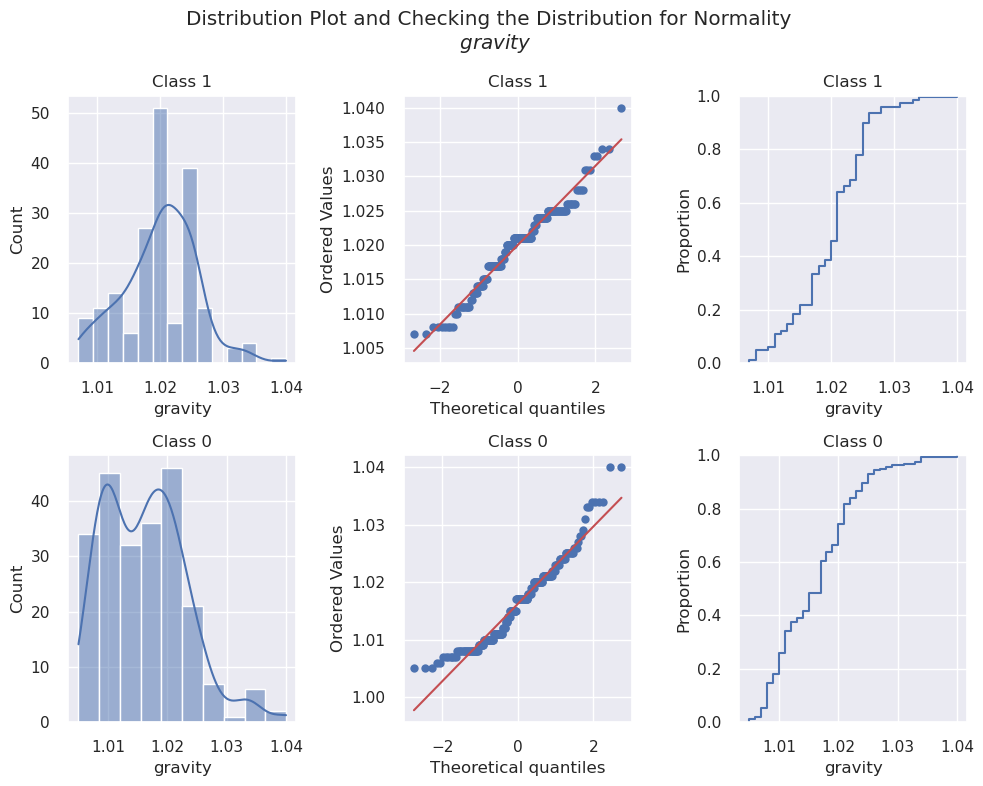

****************************************************************************************************
****************************************************************************************************


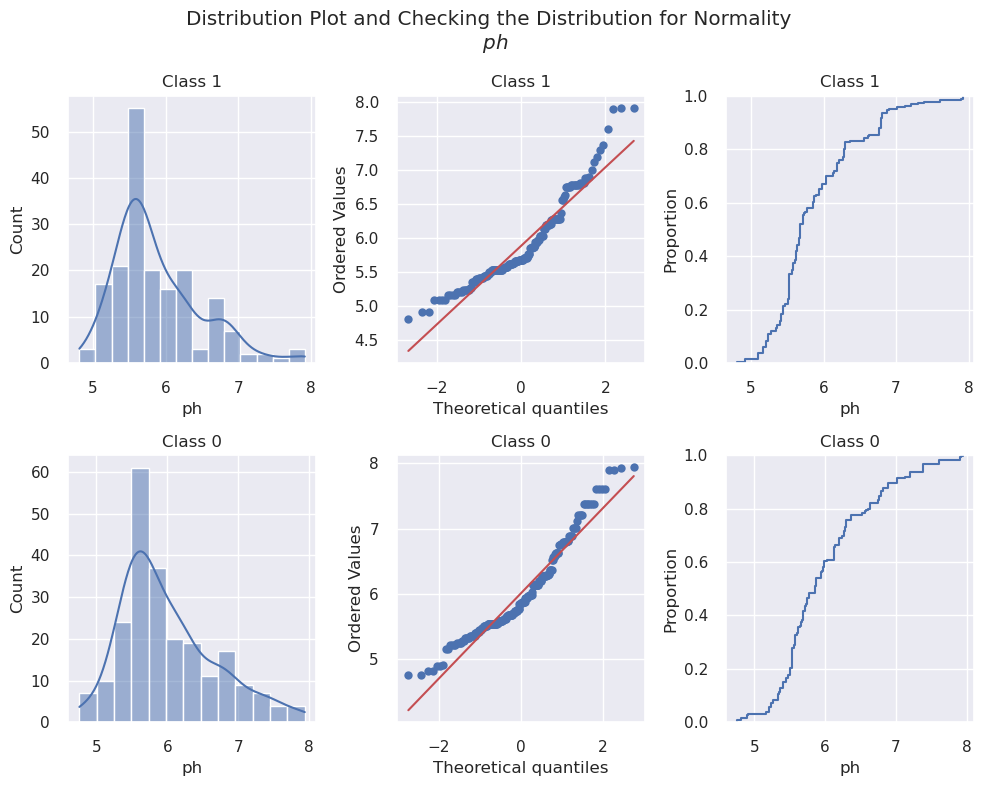

****************************************************************************************************
****************************************************************************************************


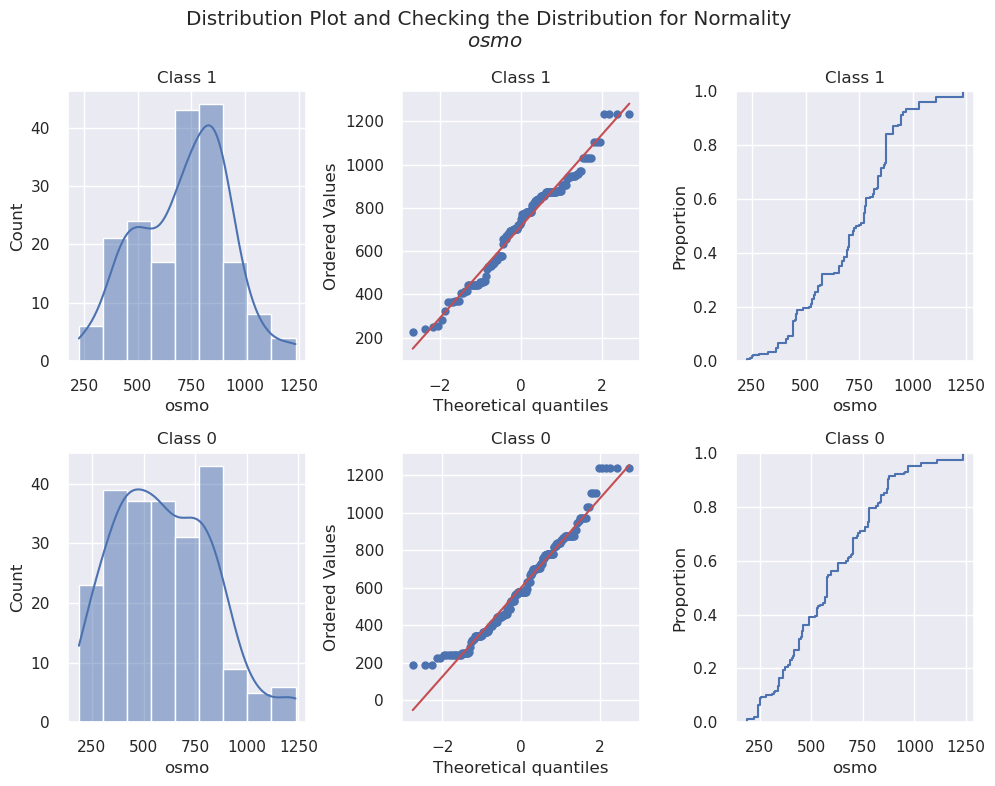

****************************************************************************************************
****************************************************************************************************


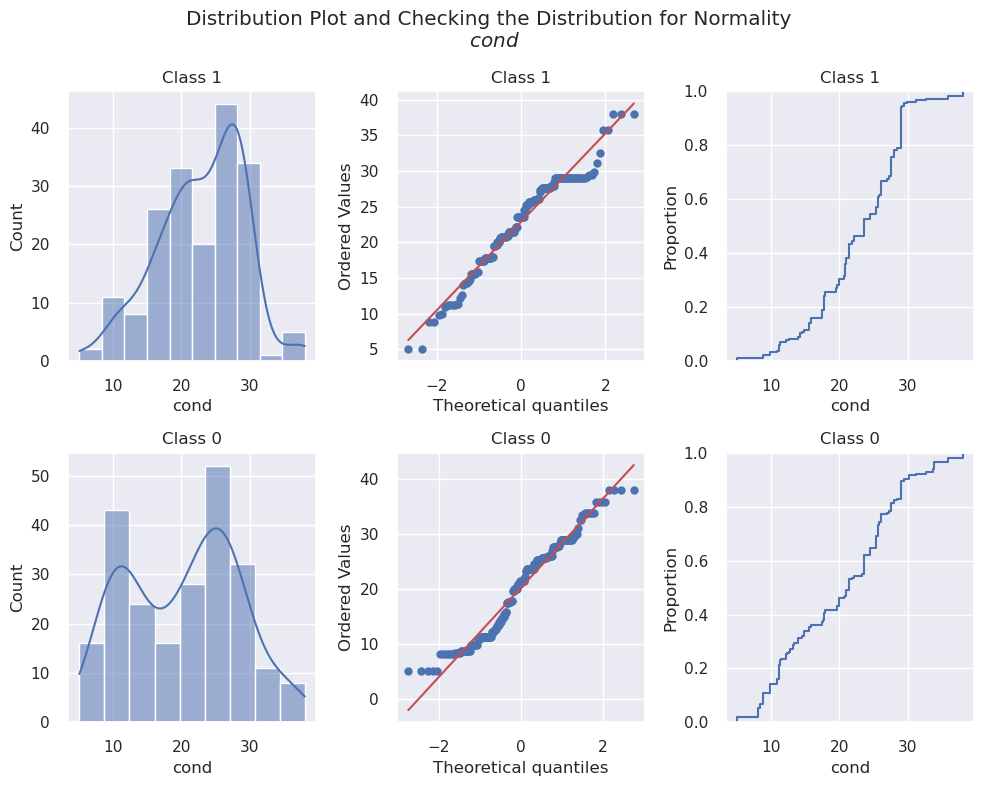

****************************************************************************************************
****************************************************************************************************


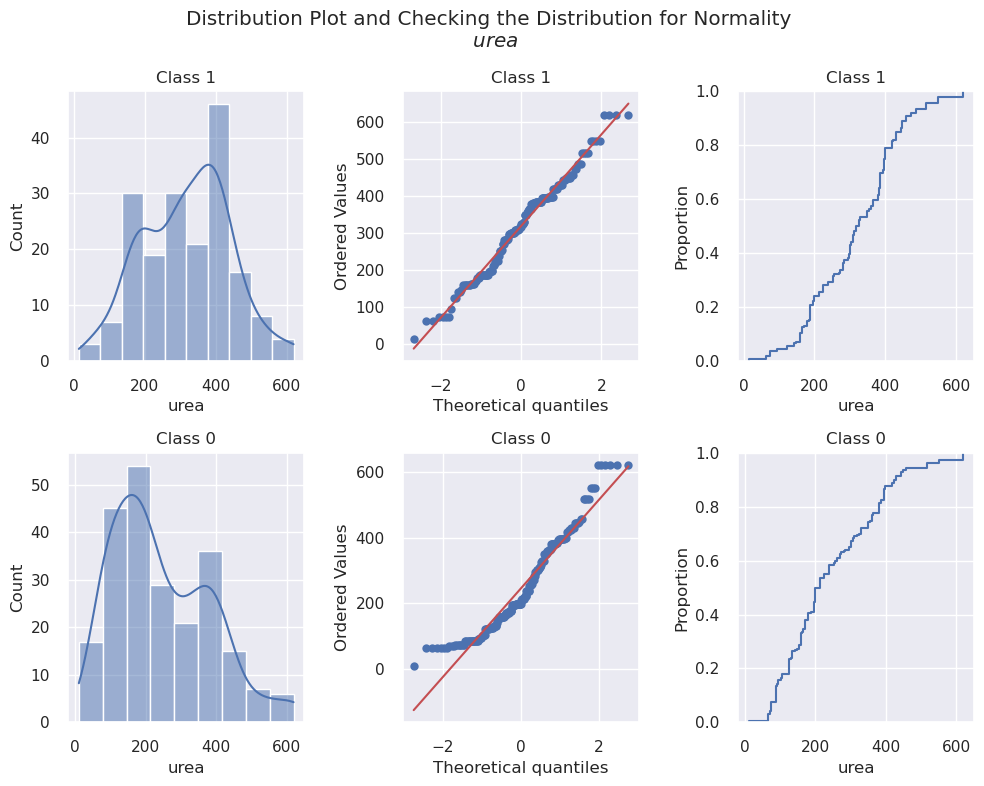

****************************************************************************************************
****************************************************************************************************


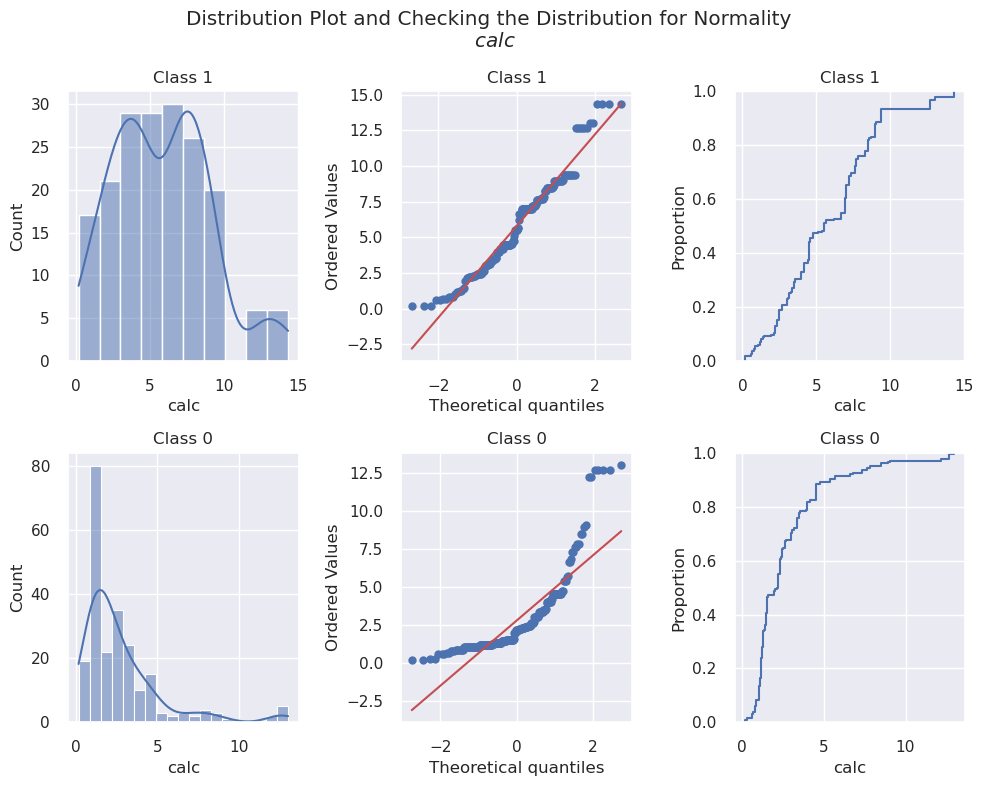

In [17]:
for i in train.columns[1:-1]:
    print('*'*100)
    print('*'*100)
    sns.set_theme()
    checking_normality_func(i)

## Preprocessing data

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
X = train.iloc[:,1:-1]
_ = scaler.fit(X)
X = scaler.transform(X)
X.shape

(414, 6)

In [20]:
Y = np.array(train.iloc[:, -1:])
Y.shape

(414, 1)

In [21]:
A = test.iloc[:,1:]
_ = scaler.fit(A)
A = scaler.transform(A)
A.shape

(276, 6)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print('-'*50)
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (331, 6), y_train: (331, 1)
--------------------------------------------------
X_test: (83, 6), y_test: (83, 1)


## Build model

### Classics Machine Learning and Ensemble methods

In [24]:
!pip install lazypredict

In [25]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


In [26]:
models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
GaussianNB                         0.75               0.75     0.75      0.75   
SGDClassifier                      0.73               0.74     0.74      0.73   
KNeighborsClassifier               0.72               0.73     0.73      0.71   
LinearSVC                          0.70               0.70     0.70      0.68   
CalibratedClassifierCV             0.70               0.70     0.70      0.68   
LogisticRegression                 0.70               0.70     0.70      0.68   
LGBMClassifier                     0.70               0.70     0.70      0.69   
AdaBoostClassifier                 0.70               0.70     0.70      0.69   
XGBClassifier                      0.70               0.70     0.70      0.69   
RandomForestClassifier             0.70               0.70     0.70      0.69   
Perceptron                         0.70               0.70     0.70      0.70   
NearestCentroid                    0.70               0.70     0.70      0.70   
LinearDiscriminantAnalysis         0.69               0.69     0.69      0.67   
RidgeClassifierCV                  0.69               0.69     0.69      0.67   
RidgeClassifier                    0.69               0.69     0.69      0.67   
NuSVC                              0.69               0.69     0.69      0.67   
QuadraticDiscriminantAnalysis      0.67               0.68     0.68      0.66   
SVC                                0.67               0.68     0.68      0.66   
BernoulliNB                        0.66               0.66     0.66      0.66   
PassiveAggressiveClassifier        0.66               0.66     0.66      0.66   
ExtraTreesClassifier               0.63               0.63     0.63      0.60   
BaggingClassifier                  0.63               0.63     0.63      0.62   
LabelSpreading                     0.61               0.62     0.62      0.60   
LabelPropagation                   0.60               0.60     0.60      0.59   
DecisionTreeClassifier             0.60               0.60     0.60      0.60   
ExtraTreeClassifier                0.57               0.57     0.57      0.56   
DummyClassifier                    0.49               0.50     0.50      0.33   

                               Time Taken  
Model                                      
GaussianNB                           0.01  
SGDClassifier                        0.01  
KNeighborsClassifier                 0.02  
LinearSVC                            0.03  
CalibratedClassifierCV               0.08  
LogisticRegression                   0.03  
LGBMClassifier                       0.30  
AdaBoostClassifier                   0.10  
XGBClassifier                        0.45  
RandomForestClassifier               0.19  
Perceptron                           0.01  
NearestCentroid                      0.02  
LinearDiscriminantAnalysis           0.02  
RidgeClassifierCV                    0.01  
RidgeClassifier                      0.02  
NuSVC                                0.02  
QuadraticDiscriminantAnalysis        0.01  
SVC                                  0.02  
BernoulliNB                          0.01  
PassiveAggressiveClassifier          0.01  
ExtraTreesClassifier                 0.15  
BaggingClassifier                    0.04  
LabelSpreading                       0.03  
LabelPropagation                     0.02  
DecisionTreeClassifier               0.02  
ExtraTreeClassifier                  0.01  
DummyClassifier                      0.01

### Use Deep Learning methods 

In [27]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout

### Built NN model

In [28]:
model = Sequential()

model.add(Input(shape=(6,)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

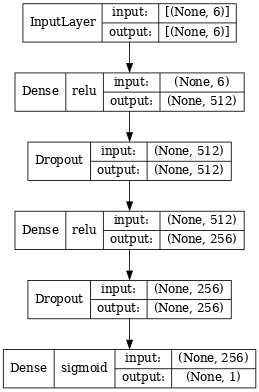

In [29]:
plot_model(model, show_shapes=True, show_layer_names=False, 
           dpi=60, show_layer_activations=True, rankdir='TB')

In [30]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=[AUC()])

In [31]:
callback = EarlyStopping(monitor='', patience=10)
reduce = ReduceLROnPlateau(monitor='', patience=10)
epochs = 1000

### Run model

In [32]:
history = model.fit(X, Y, 
                    epochs=epochs, 
                    callbacks=[callback, reduce],
                    validation_split=0.2)

Epoch 1/1000
11/11 [==============================] - 2s 39ms/step - loss: 0.6296 - auc: 0.7057 - val_loss: 0.6460 - val_auc: 0.6912 - lr: 0.0010
Epoch 2/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.5551 - auc: 0.7931 - val_loss: 0.6196 - val_auc: 0.7269 - lr: 0.0010
Epoch 3/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.5454 - auc: 0.8096 - val_loss: 0.6027 - val_auc: 0.7419 - lr: 0.0010
Epoch 4/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.5379 - auc: 0.8140 - val_loss: 0.5872 - val_auc: 0.7524 - lr: 0.0010
Epoch 5/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.5216 - auc: 0.8264 - val_loss: 0.6179 - val_auc: 0.7353 - lr: 0.0010
Epoch 6/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.5275 - auc: 0.8245 - val_loss: 0.5944 - val_auc: 0.7455 - lr: 0.0010
Epoch 7/1000
11/11 [==============================] - 0s 12ms/step - loss: 0.5112 - auc: 0.8373 - val_loss: 0.6071 - val_auc

### Plot model metrcis

In [33]:
history_data = pd.DataFrame(history.history)
epochs_history = [i+1 for i in range(epochs)]
history_data.head(5)

loss  auc  val_loss  val_auc   lr
0  0.63 0.71      0.65     0.69 0.00
1  0.56 0.79      0.62     0.73 0.00
2  0.55 0.81      0.60     0.74 0.00
3  0.54 0.81      0.59     0.75 0.00
4  0.52 0.83      0.62     0.74 0.00

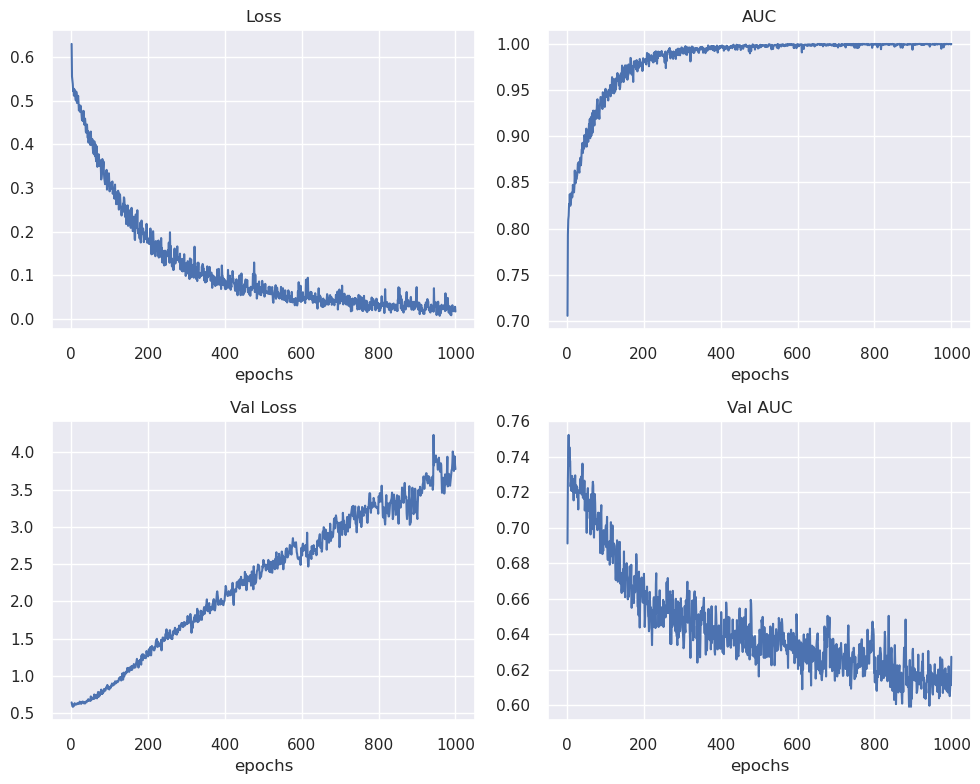

In [34]:
plt.subplot(2,2,1)
plt.plot(epochs_history, history_data['loss'])
plt.xlabel('epochs')
plt.title('Loss')

plt.subplot(2,2,2)
plt.plot(epochs_history, history_data['auc'])
plt.xlabel('epochs')
plt.title('AUC')

plt.subplot(2,2,3)
plt.plot(epochs_history, history_data['val_loss'])
plt.xlabel('epochs')
plt.title('Val Loss')

plt.subplot(2,2,4)
plt.plot(epochs_history, history_data['val_auc'])
plt.xlabel('epochs')
plt.title('Val AUC')

plt.tight_layout()
plt.show()

### Evaluate

In [35]:
results = model.evaluate(X, Y)

13/13 [==============================] - 0s 3ms/step - loss: 0.7607 - auc: 0.9438


### Predict

In [36]:
predict = model.predict(A)
predict[80:90]

9/9 [==============================] - 0s 2ms/step


array([[3.4440753e-01],
       [1.8041594e-09],
       [9.9298429e-01],
       [1.4785398e-04],
       [1.0000000e+00],
       [9.9976933e-01],
       [7.0556736e-05],
       [3.8188037e-03],
       [4.4492395e-03],
       [9.9996954e-01]], dtype=float32)

### Submit

In [37]:
sample_submission['target'] = predict

In [38]:
sample_submission.sample(10)

id  target
239  653    1.00
128  542    1.00
162  576    0.39
111  525    0.00
227  641    0.01
46   460    1.00
209  623    1.00
225  639    0.00
219  633    0.00
82   496    0.99

### Send submission

In [39]:
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)